path length:  37
sign of path:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
path type: ((1, 6.073745796940265), (3, -6.073745796940267), (1, 6.073745796940267)) $
path length:  16
sign of path:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0]
path type: ((1, 1.7062278549566148), (3, 4.678366277331246), (1, -1.583170925330568)) $
path length:  13
sign of path:
 [1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
path type: ((3, 1.2404711946833764), (1, -4.23196182260567), (3, -0.9171236695838463)) $
path length:  37
sign of path:
 [1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
path type: ((1, 2.11635513031722), (3, -5.354352666425

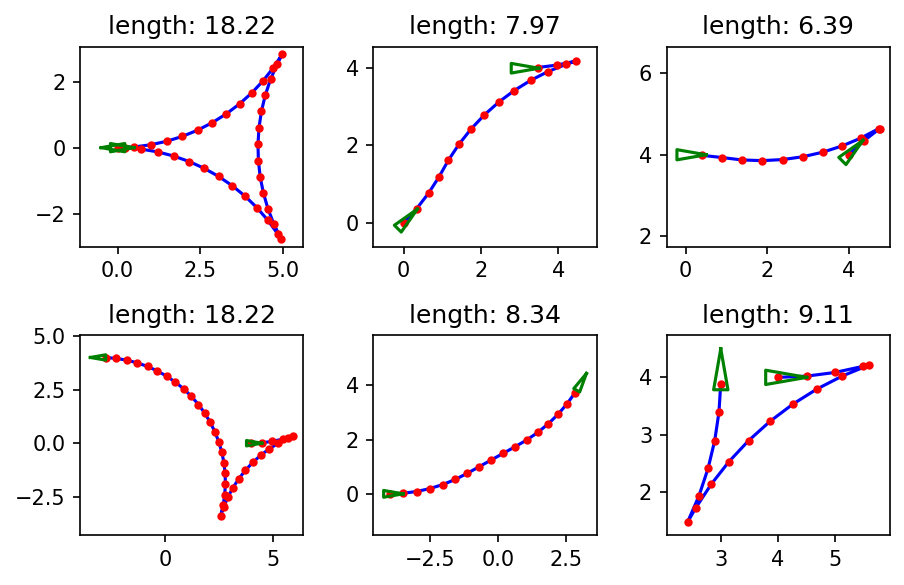

In [16]:
""" Study RS Curves: 
web: https://github.com/liespace/pyReedsShepp/blob/master/demos/demo.py
"""

import reeds_shepp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


step_size = 0.5
rho = 5.8 # turning radius，半径

# 定义六个 起点（x, y, th），终点（x, y, th）组
qs = [
    [( 0.0, 0.0,     0.0), ( 0.0, 0.0,   np.pi)],
    [( 0.0, 0.0, np.pi/4), ( 3.0, 4.0,     0.0)],
    [( 4.0, 4.0, np.pi/4), ( 0.0, 4.0,     0.0)],
    [( 4.0, 0.0,     0.0), (-3.0, 4.0,   np.pi)],
    [(-4.0, 0.0,     0.0), ( 3.0, 4.0, np.pi/3)],
    [( 4.0, 4.0,     0.0), ( 3.0, 4.0, np.pi/2)]
]

def get_point(center, radius, orin):
	x = center[0] + radius * np.cos(orin)
	y = center[1] + radius * np.sin(orin)
	return (x,y)

def plot_car(q):
    a = get_point(q[:-1], step_size, q[2])
    b = get_point(q[:-1], step_size/2, q[2]+150./180.*np.pi)
    c = get_point(q[:-1], step_size/2, q[2]-150./180.*np.pi)
    tri = np.array([a,b,c,a])
    plt.plot(tri[:,0], tri[:,1], 'g-')

def plot_path(q0, q1):
    qs = reeds_shepp.path_sample(q0, q1, rho, step_size)  # 起始点，结束点，转弯半径，步长
    print("path length: ", len(qs))
    print("sign of path:\n", [np.sign(q[4]) for q in qs])
    xs = [q[0] for q in qs]
    ys = [q[1] for q in qs]
    plt.plot(xs, ys, 'b-')
    plt.plot(xs, ys, 'r.')
    plot_car(q0)
    plot_car(q1)
    plt.axis('equal')


def plot_table(cols):
    rows = ((len(qs)) / cols)
    plt.figure(dpi=150)
    # plt.tight_layout(5)
    # plt.Figure(constrained_layout=True)
    for i,(q0, q1) in enumerate(qs):
        plt.subplot(int(rows), int(cols), int(i+1))
        # plt.figure(dpi=100)
        plot_path(q0, q1)
        dist = reeds_shepp.path_length(q0, q1, rho)
        print("path type: {} $".format(reeds_shepp.path_type(q0, q1, rho)))
        plt.title('length: {:.2f}'.format(dist))
    plt.savefig('demo.png')
    plt.tight_layout()  # 防止 title 重叠
    plt.show()


if __name__ == "__main__":
    plot_table(3)

In [34]:
"""drawArc

void drawArc(const double turn_radius, int forward, int left, 
             double &x, double &y, double &angle, double incr_dist)
{
    x = x + forward*turn_radius*(-std::sin(angle) + std::sin(angle+incr_dist/turn_radius));
    y = y + left*turn_radius*(std::cos(angle) - std::cos(angle+forward*left*incr_dist/turn_radius));
    angle = angle + forward*left*incr_dist/turn_radius;
    angle = std::atan2(std::sin(angle), std::cos(angle));
}

"""

import math
import copy


def drawArc(turn_radius, forward, left, x, y, angle, incr_dist):
    """
    绘制圆形曲线，使用右手坐标系。
    @ turn_radius: float: 转弯半径
    @ forward: bool: 是否前行（1） 
    @ left: bool: 是否左传（1）
    @ x: float: 输入点 x 坐标值
    @ y: float: 输入点 y 坐标值
    @ angle: float: 输入点 角度 值
    @ incr_dist: 当前点到下一个点的增加距离（m）
    """
#     print("drawArc: t_r, forward, left, incr_dist: {} {} {} {}".format(turn_radius, forward, left, incr_dist))
#     print("drawArc: x, y, angle: {} {} {}".format(x, y, angle))
    x = x + forward * turn_radius * (math.sin(angle) + math.sin(angle + incr_dist / turn_radius))
    y = y + left * turn_radius * (math.cos(angle) - math.cos(angle + forward * left * incr_dist / turn_radius))
    angle = angle + forward * left * incr_dist / turn_radius
    angle = math.atan2(math.sin(angle), math.cos(angle))
#     print("drawArc: x, y, angle: {} {} {}".format(x, y, angle))
    return x, y, angle



""" 1. 如何使用 drawArc 函数

知道 start_pose: (x, y, theta)

// if current car orientation is perpendicular to starting orientation,
// then the car has successfully exited
double dtheta = m_car_pose.theta() - m_start_pose.theta();
dtheta = std::abs(std::atan2(sin(dtheta), cos(dtheta)));
// PRINT_LOG("ParkingExitPathWithRadar dtheta: {}", dtheta);
double dth_temp = dtheta;


// 使用角度作跳出判断是否跳出循环
// p 表示当前点 p(x, y, theta)
// path 用来保存所有的曲线点 p(x, y, theta)
// 使用 drawArc 更新 p 坐标
// 如果车体在曲线路径之后相对于起始位置旋转90度，退出循环 

while (dth_temp < 1.571) {
    
    /**
     * @brief Set the state variables.
     *
     * @param[in] x_ coordinate x.
     * @param[in] y_ coordinate y.
     * @param[in] theta_ orientation of the car.
     * @param[in] phi_ steering angle.
     */
    p.set(x, y, angle, m_exit_direction*m_steering);
    path.push_back(p);

    drawArc(m_turn_radius, 1, m_exit_direction, x, y, angle, incr_dist);
    
    // （循环中角度的增量（angle）+ 当前车的角度（theta_c））- 车起始角度（theta_s） = 在圆弧路径之后，当前车的位置相对于起始位置旋转的角度
    // 使用这个角度来判断车是否旋转了 90 度
    dth_temp = angle + m_car_pose.theta() - m_start_pose.theta();  
    dth_temp = std::abs(std::atan2(sin(dth_temp), cos(dth_temp)));
}


"""

""" 2. 转弯半径 turn_radius 的计算方式

CAR_LEN: 5.2
CAR_WIDTH: 2.2
FRONT_WHEEL_AXIS: 0.926
REAR_WHEEL_AXIS: 0.94
FRONT_REAR_WHEEL_LEN: 2.92

steering_angle: 0.35  # default 0.35

const CarModelParams& car_params = global_param->getCarParams();
m_flow_util->m_car_front_l = car_params.astar_carFrontLength_;
m_flow_util->m_car_back_l = car_params.astar_carBackLength_;
m_flow_util->m_car_width = car_params.astar_width_;
m_flow_util->m_wheel_base = car_params.astar_car_wheel_base_;


// 转弯半径 = 轴距 / tan（转向角度），见 7204-20，对 比 底
m_turn_radius = m_wheel_base / std::tan(m_steering);

"""

# repeat above alog. sequence
# use drawArc and while loop to fill the path list
path = []  # [p1, p2, p3, ...]  # path.append(p)
p = [0, 0, 0]  # init pose: x, y, theta: car x pose, car y pose, car theta orientation

m_wheel_base = 2.92
m_steering = 0.35
m_turn_radius = m_wheel_base / math.tan(m_steering)
print("m_turn_radius: ", m_turn_radius)

m_car_pose_theta = 0
m_start_pose_theta = 0

m_exit_direction = -1 # int, 1: left, -1: right
m_forward = 1 # int, 1: forward, -1: reverse
incr_dist = 0.05

dtheta = m_car_pose_theta - m_start_post_theta
dtheta = abs(math.atan2(math.sin(dtheta), math.cos(dtheta)));
dth_temp = dtheta;
print("dth_temp: ", dth_temp)

x, y, angle = 0, 0, 0
while (dth_temp < 1.571):
#     print("p: ", p)
#     path.append(p)  # p = [x, y, angle]
    
#     drawArc(m_turn_radius, m_forward, m_exit_direction, p[0], p[1], p[2], incr_dist)
#     print("m_turn_radius, m_forward, m_exit_dir, x, y, angle, incr_dist: {} {} {} {} {} {} {}".format(m_turn_radius, m_forward, m_exit_direction, x, y, angle, incr_dist))
    x, y, angle = drawArc(m_turn_radius, m_forward, m_exit_direction, x, y, angle, incr_dist)
#     print("x, y, angle: {} {} {}".format(x, y, angle))
    p.clear()
    p.append(x)
    p.append(y)
    p.append(angle)
    print("p: ", p)
    tmp_list = copy.deepcopy(p)
    path.append(tmp_list)
    print(len(path))
#     print(path[-1])
#     print(path)
    
#     dth_temp = p[2] + m_car_pose_theta - m_start_pose_theta  
    dth_temp = angle + m_car_pose_theta - m_start_pose_theta  
    dth_temp = abs(math.atan2(math.sin(dth_temp), math.cos(dth_temp)))
    print("dth_temp: ", dth_temp)

print("path: ", path)

m_turn_radius:  7.9993755045246475
dth_temp:  0.0
p:  [0.04999967442897513, -0.0001562616893850644, -0.006250487925178503]
1
dth_temp:  0.006250487925178503
p:  [0.0, -0.0006250406526331016, -0.012500975850357006]
2
dth_temp:  0.012500975850357006
p:  [-0.1499970698760396, -0.0014063185752677615, -0.018751463775535507]
3
dth_temp:  0.018751463775535503
p:  [-0.39998567504280313, -0.0025000649339539877, -0.02500195170071401]
4
dth_temp:  0.02500195170071401
p:  [-0.7499560488274426, -0.0039062369976925228, -0.03125243962589251]
5
dth_temp:  0.03125243962589251
p:  [-1.1998945184221719, -0.005624779829488667, -0.037502927551071014]
6
dth_temp:  0.037502927551071014
p:  [-1.7497835054184416, -0.007655626288500614, -0.043753415476249516]
7
dth_temp:  0.043753415476249516
p:  [-2.3996015264937016, -0.009998697032660259, -0.05000390340142802]
8
dth_temp:  0.05000390340142802
p:  [-3.149323194250721, -0.0126539005217727, -0.05625439132660652]
9
dth_temp:  0.05625439132660652
p:  [-3.998919218

len path:  252
[0.04999967442897513, 0.0, -0.1499970698760396, -0.39998567504280313, -0.7499560488274426, -1.1998945184221719, -1.7497835054184416, -2.3996015264937016, -3.149323194250721, -3.9989192182094357, -4.948356405951281, -5.997597664415971, -7.146602001350667, -8.39532452691148, -9.743716455417252, -11.191725107255532, -12.7392939109407, -14.386362405324114, -16.132866241956243, -17.97873718760066, -19.923903126899816, -21.968288065192468, -24.11181213148268, -26.354391581560254, -28.6959388012725, -31.13636230994718, -33.675566763966515, -36.31345296049212, -39.04991784134071, -41.8848544970104, -44.81815217085755, -47.84969626342381, -50.97936833691335, -54.20704611982007, -57.53260351170454, -60.955910588120545, -64.47683360569107, -68.0952350073334, -71.81097342763331, -75.62390369836798, -79.53387685417748, -83.54074013838463, -87.64433700896298, -91.84450714465265, -96.14108645122386, -100.5339070678878, -105.02279737385474, -109.60758199503898, -114.28808181091044, -119

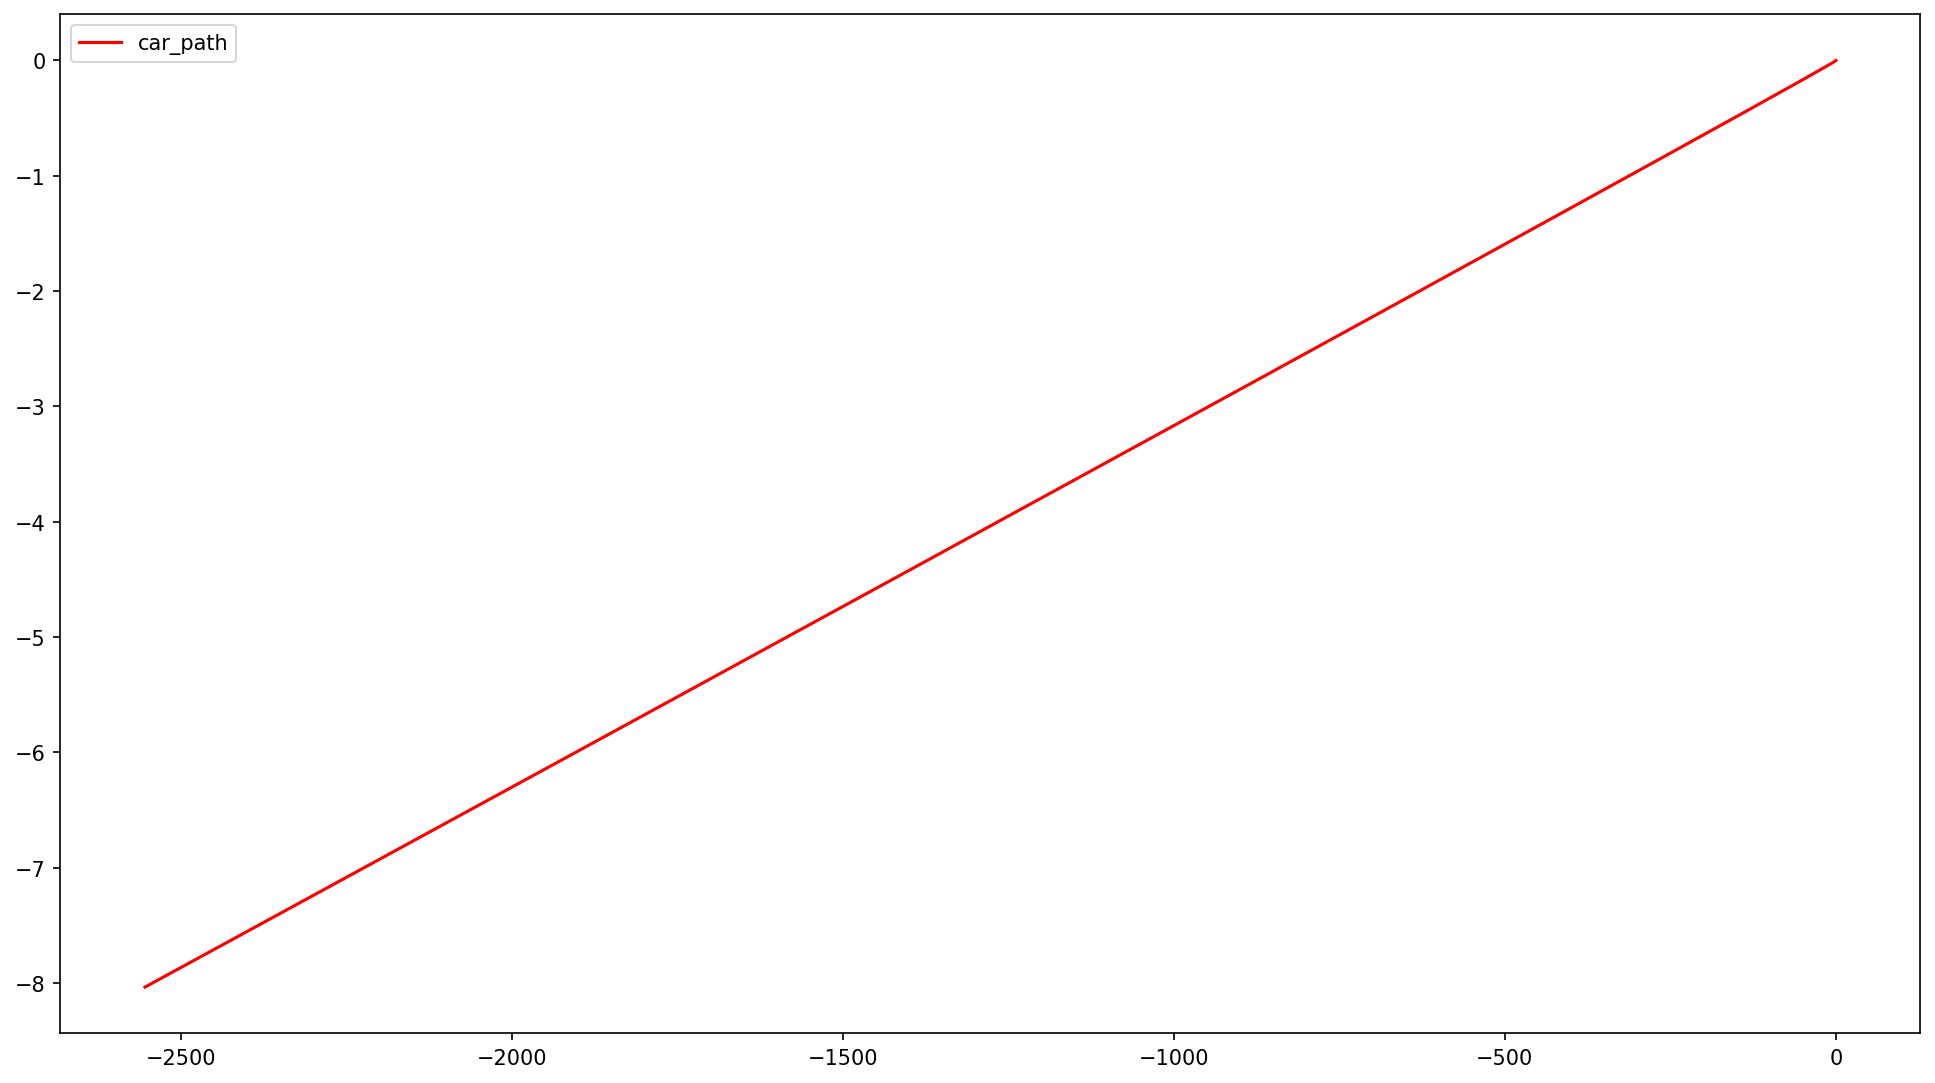

In [35]:
import matplotlib.pyplot as plt

car_x = []
car_y = []

print("len path: ", len(path))
for i in range(len(path)):
    car_x.append(path[i][0])    
    car_y.append(path[i][1])
   

plt.figure(figsize=(16,9), dpi=150) # parallel

plt.plot(car_x, car_y, label="car_path", color="r")
print(car_x)

plt.legend(loc="best")

plt.show()